<a href="https://colab.research.google.com/github/Ghzraza/Neural-Circuit-Dynamics-Simulation-mPFC-Stress-Model/blob/main/neural_circuit_mapping_example_(labonete_%2Bdynamica_specific).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Neural Circuit Dynamics — mPFC Stress Simulation (Colab demo)

**Purpose:** Compact pipeline that (1) simulates mPFC-like population activity under behaviorally-driven inputs, (2) compares baseline vs stress-altered coupling, (3) computes time-resolved functional connectivity and graph metrics, and (4) demonstrates an AI-based predictive model (GRU).

**Goal** This notebook is explicitly designed to map to the Labonté Lab + Dynamica Research Lab goals: temporal dynamics of neuronal circuit activity in mPFC, network-based analysis, and AI-based in-silico predictive modeling for stress-related circuit reconfiguration.


SyntaxError: invalid syntax (ipython-input-956467132.py, line 3)

In [3]:
# If a package is missing in Colab, uncomment and run the following:
# !pip install networkx seaborn torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
from typing import Tuple

# reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
sns.set(style="whitegrid")

print("Ready. PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")


Ready. PyTorch device: cpu


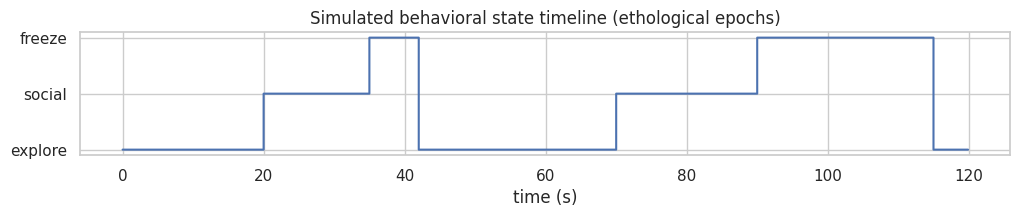

In [4]:
# Simulation parameters (tunable)
T = 1200          # frames/timepoints
fps = 10          # frames per second (for interpretation)
N = 50            # number of neurons (mPFC-like)
time = np.arange(T) / fps

# Define behavioral states timeline (ethological epochs)
# 0 = explore, 1 = social, 2 = freeze
state = np.zeros(T, dtype=int)
epochs = [(50,200,0),(200,350,1),(350,420,2),(420,700,0),(700,900,1),(900,1150,2)]
for s,e,st in epochs:
    state[s:e] = st

# quick visualization of behavior timeline
plt.figure(figsize=(12,1.6))
plt.plot(time, state, drawstyle='steps-post', linewidth=1.5)
plt.yticks([0,1,2], ['explore','social','freeze'])
plt.xlabel('time (s)')
plt.title('Simulated behavioral state timeline (ethological epochs)')
plt.show()


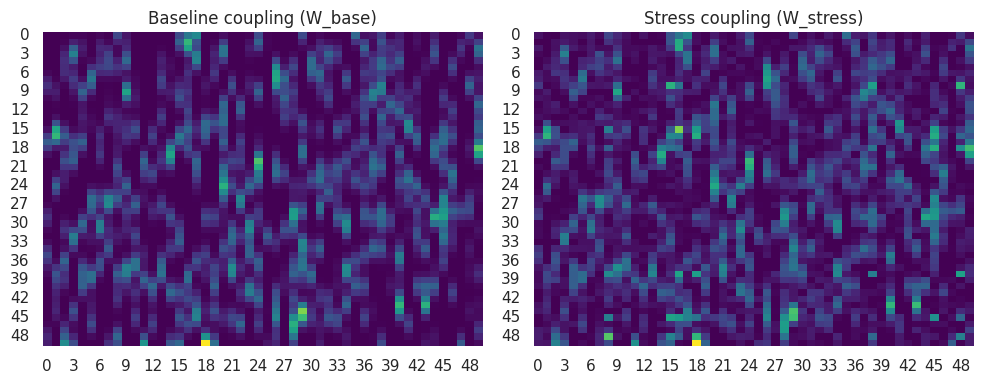

Stress ensemble neuron indices: [16  8 18 45 15 48 38]


In [5]:
# Create baseline sparse coupling matrix (functional weights 0..1)
p_conn = 0.12
W_base = (np.random.rand(N,N) * (np.random.rand(N,N) < p_conn)).astype(float)
W_base = (W_base + W_base.T) / 2.0                           # make symmetric-ish
W_base = gaussian_filter1d(W_base, sigma=1, axis=0)
W_base = np.clip(W_base, 0, 1)

# Define a stress ensemble (subset of neurons that become hyper-connected under stress)
stress_idx = np.random.choice(N, size=max(3,int(0.15*N)), replace=False)

# Create stress coupling matrix by boosting intra-ensemble connectivity and adding noise
W_stress = W_base.copy()
for i in stress_idx:
    for j in stress_idx:
        W_stress[i,j] = np.clip(W_stress[i,j] + 0.35 * np.random.rand(), 0, 1)
W_stress = np.clip(W_stress + 0.02*np.random.randn(N,N), 0, 1)

# Visualize baseline vs stress coupling
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('Baseline coupling (W_base)'); sns.heatmap(W_base, cmap='viridis', cbar=False)
plt.subplot(1,2,2); plt.title('Stress coupling (W_stress)'); sns.heatmap(W_stress, cmap='viridis', cbar=False)
plt.tight_layout(); plt.show()

# print stress indices for inspection
print("Stress ensemble neuron indices:", stress_idx)


In [10]:
#External drive function (fixed-length vectors)
def external_drive_for_state(s:int, N:int) -> np.ndarray:
    """
    Return an external drive vector (length N) influenced by behavioral state s.
    We split the population into 3 functional groups here for clarity:
      - group0: indices [0 : N//3)
      - group1: indices [N//3 : 2*N//3)
      - group2: indices [2*N//3 : N)
    Each state preferentially drives one group.
    """
    drive = np.zeros(N, dtype=float)
    g0 = np.arange(0, N//3)
    g1 = np.arange(N//3, 2*(N//3))
    g2 = np.arange(2*(N//3), N)
    if s == 0:   # explore
        drive[g0] = 0.20
    elif s == 1: # social
        drive[g1] = 0.35
    elif s == 2: # freeze / defensive
        drive[g2] = 0.15
    return drive

# sanity check
print("drive shapes:", external_drive_for_state(0,N).shape, external_drive_for_state(1,N).shape)


drive shapes: (50,) (50,)


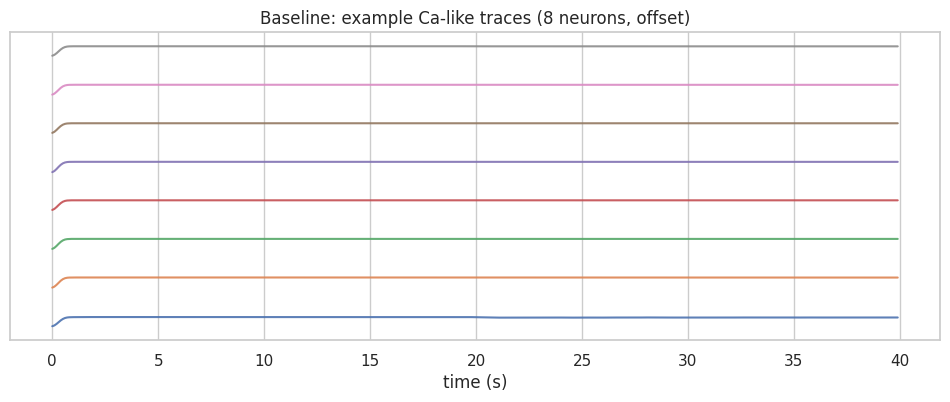

In [11]:
 #Simulate Ca²⁺-like population activity (baseline & stress)
# Initialize activity arrays
activity_base = np.zeros((T,N), dtype=float)
activity_stress = np.zeros((T,N), dtype=float)
activity_base[0] = 0.05 * np.random.randn(N)
activity_stress[0] = 0.05 * np.random.randn(N)

# Simple recurrent update (nonlinear) to simulate population dynamics
for t in range(T-1):
    drive = external_drive_for_state(int(state[t]), N)
    activity_base[t+1] = np.tanh(activity_base[t] @ W_base + drive + 0.04*np.random.randn(N))
    # for stress: use baseline early, then switch to stress coupling to mimic chronic effect onset
    if t < T//2:
        activity_stress[t+1] = np.tanh(activity_stress[t] @ W_base + drive + 0.04*np.random.randn(N))
    else:
        activity_stress[t+1] = np.tanh(activity_stress[t] @ W_stress + drive + 0.04*np.random.randn(N))

# Low-pass filter to mimic calcium kinetics (smoothing)
activity_base_smooth = gaussian_filter1d(activity_base, sigma=2, axis=0)
activity_stress_smooth = gaussian_filter1d(activity_stress, sigma=2, axis=0)

# Plot example traces (first 8 neurons) for baseline
plt.figure(figsize=(12,4))
for i in range(8):
    plt.plot(time[:400], activity_base_smooth[:400,i] + i*3, alpha=0.9)
plt.title('Baseline: example Ca-like traces (8 neurons, offset)')
plt.xlabel('time (s)'); plt.yticks([]); plt.show()



Social onsets: [200, 700]


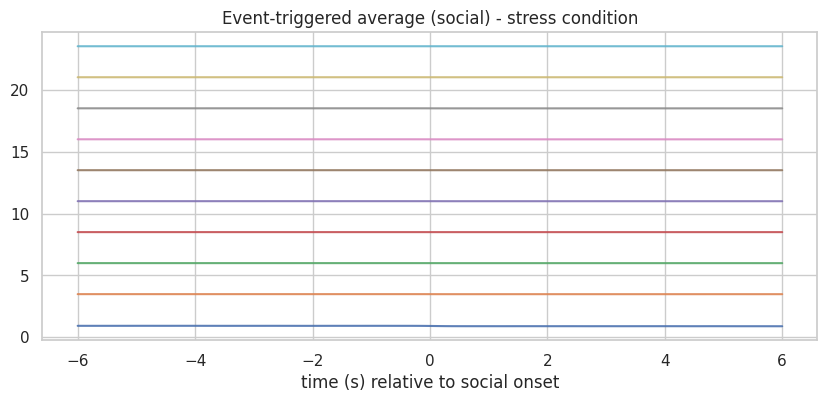

In [12]:
#Event-triggered average (ETA) around social onsets
# Detect onsets of 'social' epochs
social_onsets = [t for t in range(1,T) if state[t]==1 and state[t-1]!=1]
print("Social onsets:", social_onsets)

# Extract windows and compute ETA for stress condition
win = 60  # frames (~6 s) before/after
eta_list = []
for on in social_onsets:
    if on-win >= 0 and on+win < T:
        eta_list.append(activity_stress_smooth[on-win:on+win+1])
eta_arr = np.array(eta_list)      # (events, window_len, N)
if eta_arr.size == 0:
    print("Warning: no valid events for ETA (check epoch settings)")
else:
    eta_mean = np.nanmean(eta_arr, axis=0)
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.plot(np.linspace(-win,win,2*win+1)/fps, eta_mean[:,i] + i*2.5, alpha=0.9)
    plt.xlabel('time (s) relative to social onset'); plt.title('Event-triggered average (social) - stress condition'); plt.show()


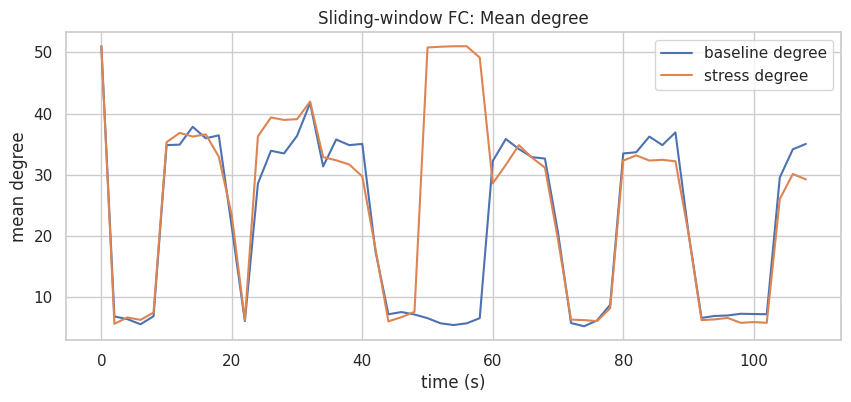

In [13]:
#Sliding-window functional connectivity & network metrics
from scipy.stats import pearsonr
def sliding_window_fc(activity:np.ndarray, window:int=120, step:int=20) -> Tuple[np.ndarray, list]:
    T,N = activity.shape
    starts = list(range(0, T-window+1, step))
    fcs = []
    for s in starts:
        seg = activity[s:s+window]
        C = np.corrcoef(seg.T)
        C = np.nan_to_num(C)
        fcs.append(C)
    return np.array(fcs), starts

fcs_base, starts = sliding_window_fc(activity_base_smooth, window=120, step=20)
fcs_stress, _ = sliding_window_fc(activity_stress_smooth, window=120, step=20)

def network_metrics_from_fc(fc_matrices, thr=0.35):
    degs=[]; clusts=[]; mods=[]
    for C in fc_matrices:
        A = (np.abs(C) > thr).astype(int)
        G = nx.from_numpy_array(A)
        degs.append(np.mean([d for _,d in G.degree()]))
        clusts.append(nx.average_clustering(G))
        try:
            comms = list(nx.algorithms.community.greedy_modularity_communities(G))
            mods.append(len(comms))
        except:
            mods.append(np.nan)
    return np.array(degs), np.array(clusts), np.array(mods)

deg_b,clust_b,mod_b = network_metrics_from_fc(fcs_base)
deg_s,clust_s,mod_s = network_metrics_from_fc(fcs_stress)

plt.figure(figsize=(10,4))
plt.plot(np.array(starts)/fps, deg_b, label='baseline degree')
plt.plot(np.array(starts)/fps, deg_s, label='stress degree')
plt.xlabel('time (s)'); plt.ylabel('mean degree'); plt.title('Sliding-window FC: Mean degree'); plt.legend(); plt.show()


In [14]:
#Small GRU predictor: prepare dataset + model
# Prepare sequences for GRU prediction using post-perturbation stress activity
data = activity_stress_smooth.copy()
L = 10    # history length
X=[]; Y=[]
for t in range(L, data.shape[0]-1):
    X.append(data[t-L:t])   # (L, N)
    Y.append(data[t+1])     # (N,)
X = np.stack(X).astype(np.float32)
Y = np.stack(Y).astype(np.float32)

# train/val split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_t = torch.tensor(X_train).to(device)
Y_train_t = torch.tensor(Y_train).to(device)
X_val_t = torch.tensor(X_val).to(device)
Y_val_t = torch.tensor(Y_val).to(device)

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
    def forward(self, x):
        h, _ = self.gru(x)
        out = self.fc(h[:, -1, :])
        return out

model = GRUPredictor(N, hidden_size=128).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# quick training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    opt.zero_grad()
    pred = model(X_train_t)
    loss = loss_fn(pred, Y_train_t)
    loss.backward()
    opt.step()
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = loss_fn(val_pred, Y_val_t)
    print(f"Epoch {epoch+1}/{epochs} - train loss: {loss.item():.5f} - val loss: {val_loss.item():.5f}")


Epoch 1/12 - train loss: 1.11700 - val loss: 0.96620
Epoch 2/12 - train loss: 0.95635 - val loss: 0.82004
Epoch 3/12 - train loss: 0.81172 - val loss: 0.68546
Epoch 4/12 - train loss: 0.67848 - val loss: 0.56023
Epoch 5/12 - train loss: 0.55446 - val loss: 0.44389
Epoch 6/12 - train loss: 0.43921 - val loss: 0.33801
Epoch 7/12 - train loss: 0.33430 - val loss: 0.24569
Epoch 8/12 - train loss: 0.24283 - val loss: 0.17036
Epoch 9/12 - train loss: 0.16823 - val loss: 0.11435
Epoch 10/12 - train loss: 0.11284 - val loss: 0.07732
Epoch 11/12 - train loss: 0.07638 - val loss: 0.05612
Epoch 12/12 - train loss: 0.05568 - val loss: 0.04612


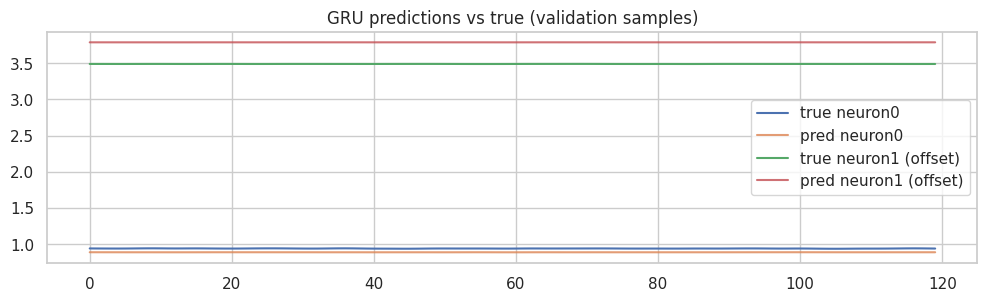

In [15]:
#Evaluate & plot predicted vs true for a few neurons
# Evaluate predictions on a small validation subset
model.eval()
with torch.no_grad():
    sample_pred = model(X_val_t[:120]).cpu().numpy()
true = Y_val[:120]

# plot neuron 0 and neuron 1 predictions vs true
plt.figure(figsize=(12,3))
plt.plot(true[:,0], label='true neuron0'); plt.plot(sample_pred[:,0], label='pred neuron0', alpha=0.8)
plt.plot(true[:,1] + 2.5, label='true neuron1 (offset)'); plt.plot(sample_pred[:,1] + 2.5, label='pred neuron1 (offset)', alpha=0.8)
plt.legend(); plt.title('GRU predictions vs true (validation samples)'); plt.show()


In [ ]:
## Discussion: mapping this demo to the Labonté + Dynamica PhD project

- **Temporal dynamics & ensemble recruitment:** sliding-window FC and event-triggered averages demonstrate how neuronal subsets' recruitment varies with behavior and after a stress-like perturbation — directly aligned with the project's aim to study recruitment and consolidation of neuronal representations in mPFC.
- **Network theory metrics:** degree, clustering, and modularity provide interpretable features that quantify circuit reorganization over time, matching Dynamica's interest in network-based temporal analysis.
- **AI predictive modeling:** the GRU forecasting is a lightweight in-silico predictive model that can be extended to predict behavioral responses or neuronal representation trajectories across sexes and conditions.
- **Neurophotonic relevance:** smoothed synthetic traces mimic processed Ca²⁺ fluorescence signals typically used in miniscope/fiber photometry experiments.
- **Next steps to increase biological realism:** seed graph topology from synaptic tracing/scRNA clusters, ingest real Ca²⁺ recordings (miniscope), and extend the predictive model to behavior prediction and sex-specific modeling.
